In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import math


#sns.set_theme()
#matplotlib.rc('xtick', labels
# ize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

path=os.getcwd()



def fourierT(f):

    return (np.fft.fftshift(np.fft.fft(np.fft.fftshift(f))))


def fourierI(f):

    return (np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f))))



In [2]:
def new_methodc(I1,I2,phi1,phi2,gamma,S,C,B,T,dt,h,cond=1):
    '''
    Este codigo calcula un paso espacial. Recibe un array
    con la intensidad y la fase. Modifica ese array para dar lugar al
    siguiente paso espacial.

    '''

    I1n_j = I1  # Recibe In_j
    phi1n_j = phi1  # Recibe phin_j
    I2n_j = I2  # Recibe In_j
    phi2n_j = phi2  # Recibe phin_j

    I1new = []
    phi1new = []
    I2new = []
    phi2new = []

    # Ciclo para calcular cada componente del array que contendra el siguiente
    # paso espacial
    for j in range(0,len(I1n_j)):

        I1tn_j = (I1n_j[j]+I1n_j[j-1])*0.5
        deltaI1n_j = I1n_j[j]-I1n_j[j-1]
        deltatheta1 = phi1n_j[j]-phi1n_j[j-1]
        deltatau1n_j = min([abs(deltatheta1),abs(deltatheta1+2*np.pi),abs(deltatheta1-2*np.pi)])

        I2tn_j = (I2n_j[j]+I2n_j[j-1])*0.5
        deltaI2n_j = I2n_j[j]-I2n_j[j-1]
        deltatheta2 = phi2n_j[j]-phi2n_j[j-1]
        deltatau2n_j = min([abs(deltatheta2),abs(deltatheta2+2*np.pi),abs(deltatheta2-2*np.pi)])

 
        if cond==1:
           


            if abs(deltatheta1) == deltatau1n_j:
                deltaphi1n_j = deltatheta1
            elif  abs(deltatheta1+2*np.pi) == deltatau1n_j:
                deltaphi1n_j = deltatheta1 + 2*np.pi
            else:
                deltaphi1n_j = deltatheta1 - 2*np.pi
                
            I1n1_j = I1n_j[j]-h/dt*gamma*S*((3*I1tn_j+B*I2tn_j)*deltaI1n_j
                                            +2*B*I1tn_j*deltaI2n_j)
            
            phi1tn1_j = phi1n_j[j]-h/dt*gamma*(T*(deltaI1n_j+B*deltaI2n_j)
                                    +S*(I1tn_j+B*I2tn_j)*deltaphi1n_j)
        
            phi1n1_j = phi1tn1_j + h*gamma*(I1n1_j+C*I2n_j[j])

            I1new.append(I1n1_j) # Intensidad en el siguiente paso espacial
            phi1new.append(phi1n1_j) #vfase en el siguiente paso espacial

        else:
            if abs(deltatheta2) == deltatau2n_j:
                deltaphi2n_j = deltatheta2
            elif  abs(deltatheta2+2*np.pi) == deltatau2n_j:
                deltaphi2n_j = deltatheta2 + 2*np.pi
            else:
                deltaphi2n_j = deltatheta2 - 2*np.pi
                

            I2n1_j = I2n_j[j]-h/dt*gamma*S*((3*I2tn_j+B*I1tn_j)*deltaI2n_j
                                            +2*B*I2tn_j*deltaI1n_j)
            phi2tn1_j = phi2n_j[j]-h/dt*gamma*(T*(deltaI2n_j+B*deltaI1n_j)
                                    +S*(I2tn_j+B*I1tn_j)*deltaphi2n_j
                                    )
            phi2n1_j = phi2tn1_j + h*gamma*(I2n1_j+C*I1n_j[j])

       
            I2new.append(I2n1_j) # Intensidad en el siguiente paso espacial
            phi2new.append(phi2n1_j) #vfase en el siguiente paso espacial

      
        # I2n_j = I2n1_j
        # phi2n_j = phi2n1_j
    if cond == 1:
        return np.sqrt(np.array(I1new))*np.exp(1j*np.array(phi1new))
    else:

        return np.sqrt(np.array(I2new))*np.exp(1j*np.array(phi2new))
    


def fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,lenght,dt,steps):

    
    h = lenght/steps
  
    betas_freq1 = sum((1j)**(i+1)*betas1[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas1)))
    betas_freq2 = sum((1j)**(i+1)*betas2[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas2)))
    
    UD1 = np.exp(-h*0.5*betas_freq1,dtype=complex)
    UD2 = np.exp(-h*0.5*(betas_freq2+1j*delta*V),dtype=complex)



    for i in range(steps):
        
        stability1 = (h/dt*gammas[0]*S[0]*np.amax(3*np.abs(A1)**2+B[0]*np.abs(A2)**2))
        stability2 = (h/dt*gammas[1]*S[1]*np.amax(3*np.abs(A1)**2+B[1]*np.abs(A2)**2))

        # if stability1 < 1 and stability2 < 2:
        #     print(True)

        A1a = fourierI(UD1*fourierT(A1))
        A2a = fourierI(UD2*fourierT(A2))
        I1 = np.abs(A1a)**2
        phi1 = np.angle(A1a)
        I2 = np.abs(A2a)**2
        phi2 = np.angle(A2a)
        

        A1as = new_methodc(I1,I2,phi1,phi2,gammas[0],S[0],C[0],B[0],T,dt,h/2)

        I1as = np.abs(A1as)**2
        phi1as = np.angle(A1as)

        A2aa = new_methodc(I1as,I2,phi1as,phi2,gammas[1],S[1],C[1],B[1],T,dt,h,cond=2)

        I2aa = np.abs(A2aa)**2
        phi2aa = np.angle(A2aa)
        
        A1aa = new_methodc(I1as,I2aa,phi1as,phi2aa,gammas[0],S[0],C[0],B[0],T,dt,h/2)
        
        A1 = fourierI(UD1*fourierT(A1aa))
        A2 = fourierI(UD2*fourierT(A2aa))

    return A1,A2

def Delta_landa1(y_data,x_data):

    
    cs=CubicSpline(x_data,y_data)
    new_xdata=np.linspace(min(x_data),max(x_data),len(x_data)*3)
    Y=cs(new_xdata)
    medium_value=np.max(Y)*0.01
    M_V=[]
    wl_s=[]
    pow_s=[]
    
    for i in range(len(Y)):
        if Y[i]>medium_value:
            
            M_V.append(i)
            wl_s.append(new_xdata[i])
            pow_s.append(Y[i])
            

    x1=new_xdata[np.min(M_V)]; 
    x2=new_xdata[np.max(M_V)]
    return abs(x2-x1)



def stokes_params(A1,A2,phi):

    A1_max  = np.amax(np.abs(A1))
    A2_max  = np.amax(np.abs(A2))
    S0 = A1_max**2+A2_max**2
    S1 = A1_max**2-A2_max**2
    S2 = 2*A1_max*A2_max*np.cos(phi)
    S3 = 2*A1_max*A2_max*np.sin(phi)


In [3]:
def anim2(k,cc):
    
    wl = 1550e-9      #reference wavelength [m]
    c = 299792458
    n = 2**12    # number of grid points
    TimeWindow = 12*1e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
    w0 = (2*np.pi*c)/wl  #reference frequency [Hz]
    length = 2.0             #ibre length [m]
    D = -1e-12*1e9*1e-3 #Dispersion
    dD = 0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas1=[beta2,beta3]
    betas2 = [beta2,beta3]
    P0 = 10e-3 # Potencia media.
    gamma = 10.8*1e-3 # Coeficiente de nolinealidad fibra
    tau1 = 300e-15
    frep = 37.5*1e6  # Tasa de repetición.
    Ppeak = P0/(frep*tau1)
    T = 2*1e-15
    gammas = [gamma,gamma]
    B = [0,0]
    BB = 2/3
    C = [BB,BB]
    c = 299792458;   
    wl1 = 1556e-9
    w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
    wl2 = 1556e-9
    w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
    S = [1/w01,1/w01]        
    delta = 0
    steps = 30
    tau1 = 320.000*1e-15
    A1 = np.cos(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)*np.exp(-1j*cc)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    A2 = np.sin(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1) #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    dw = np.pi/(n*dT)
    V = np.array([j*dw for j in range(-int(n),int(n))])
    W = V+w0
    WL = ((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid
    y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)

    f = plt.figure(figsize = (15,6))

    plt.subplot(121)

    yf = fourierT(y1+y2)
    y = np.abs(yf/np.amax(yf))**2
    plt.plot(WL*1e9,y, label = 'Propagated spectrum')
    plt.plot(WL*1e9,np.abs(fourierT(A1+A2))**2/np.amax(np.abs(fourierT(A1+A2))**2), label = 'Initial spectrum')
    plt.xlim(1400,1800)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()

    ylog = 10*np.log10(y)
    yin = fourierT(A1+A2)/np.amax(fourierT(A1+A2))
    ylog_in = 10*np.log10(np.abs(yin)**2)
    
    plt.subplot(122)
    plt.plot(WL*1e9,ylog,'r',label ='Propagated spectrum')
    plt.plot(WL*1e9,ylog_in,'--k',label = 'Initial spectrum')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()
    plt.xlim(1300,1750)
    plt.ylim(-60,10)
    print(Delta_landa1(y,np.sort((2*np.pi*c/W))*1e9))

    f = plt.figure(figsize = (15,6))
    plt.plot(A1,A2)
    print(A2)
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        k= widgets.FloatSlider(min=0,max=2*np.pi,value=0,step=0.001,**opc),
        cc = widgets.FloatSlider(min=0,max=2*np.pi,value=0,step=0.001,**opc)
     
        
        #mm
        );

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='k', max=6.283185307179586, …

In [7]:
wl = 1550e-9      #reference wavelength [m]
c = 299792458
n = 2**12    # number of grid points
TimeWindow = 12*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
w0 = (2*np.pi*c)/wl  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D = -1e-12*1e9*1e-3 #Dispersion
dD = 0.006*1e-12*1e9**2*1e-3  #Dispersion slope
beta2=-wl**2/(2*np.pi*c)*D
beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
betas1=[beta2,beta3]
betas2 = [beta2,beta3]
P0=10e-3 # Potencia media.
gamma = 10.8*1e-3 # Coeficiente de nolinealidad fibra
tau1 = 320e-15
frep = 37.5*1e6  # Tasa de repetición.
Ppeak = P0/(frep*tau1)
T = 2*1e-15
gammas = [gamma,gamma]
B = [0,0]
C = [2/3,2/3]
c = 299792458;   
wl1 = 1556e-9
w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
wl2 = 1556e-9
w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
S = [1/w01,1/w01]        
delta = 0
steps = 40
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n),int(n))])
W = V+w0
WL = np.sort((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid

In [8]:
N_phase = 25
N_angles = 100
values_phase = np.linspace(0,2*np.pi,N_phase)
values_angles = np.linspace(0,2*np.pi,N_angles)
spectral = np.zeros((N_angles,N_phase))


for i,theta in enumerate(values_angles):
    for j,k in enumerate(values_phase):
        A1 = np.cos(theta)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)*np.exp(1j*k)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
        A2 = np.sin(theta)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)
        y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)
        yf = fourierT(y1+y2)
        y = np.abs(yf/np.amax(yf))**2
        spectral[i,j] = Delta_landa1(y,WL*1e9)

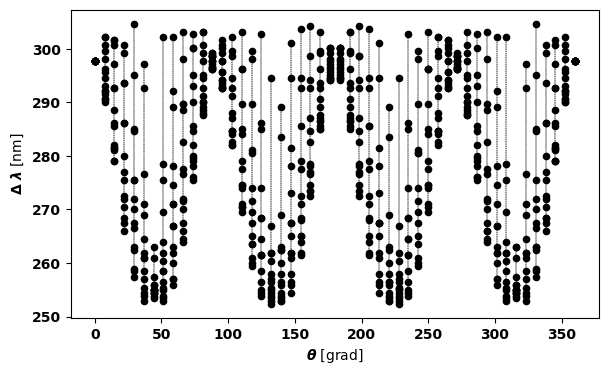

In [32]:
f = plt.figure(figsize = (15,4))

plt.subplot(121)
for i in range(N_angles):
    plt.plot(np.ones(N_phase)*values_angles[i]*180/np.pi ,spectral[i,:], color = 'black', marker='o', linestyle='dashed',linewidth=0.3, markersize=4.5)
    plt.xlabel(r'$\theta$ [grad]' )
    plt.ylabel('$\Delta$ $\lambda$ [nm]')
